In [1]:
import numpy as np
import sklearn
import sklearn.feature_extraction, sklearn.decomposition
import skimage.io, skimage.color, skimage.transform
import matplotlib.pyplot as plt
import time

In [2]:
# training image
img1 = skimage.io.imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/gray/159029.jpg')/255

# test image 
img2 = skimage.io.imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/gray/170057.jpg')/255

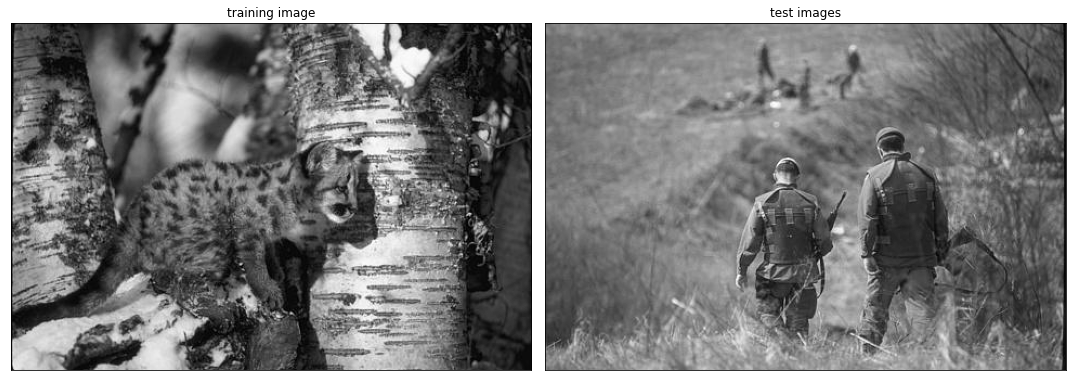

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15,12))

ax[0].imshow(img1, cmap='gray')
ax[0].set_title('training image')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('test images')
for i in range(2):
  ax[i].set_xticks([]), ax[i].set_yticks([])
plt.tight_layout()

In [4]:
def train_dico(image, k, patch_size):
    patch_dim = np.prod(patch_size)
    patches = sklearn.feature_extraction.image.extract_patches_2d(image, patch_size=patch_size).reshape(-1, patch_dim)
    
    patches -= np.mean(patches, axis=0)
    patches /= np.std(patches, axis=0)
    print("training on {} patches, patch size {}".format(len(patches), patch_size))

    dico = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=k, alpha=1, n_iter=1000, n_jobs=6, 
                                                             transform_algorithm='lars', random_state=42)
    t1 = time.time()
    dico.fit(patches)
    t2 = time.time()
    print("done, time elapsed {} sec".format(t2 - t1))
    return dico

# dict params
k = 100
patch_size = (9,9)
dico = train_dico(img1, k, patch_size)


training on 148049 patches, patch size (9, 9)
done, time elapsed 12.94345498085022 sec


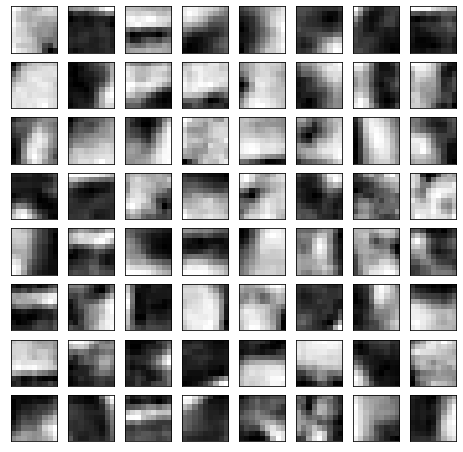

In [5]:
# plotting part of the dictionary
v = dico.components_
fig, ax = plt.subplots(8,8, figsize=(8,8))

count = 0
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(v[count].reshape(patch_size), cmap='gray')
        ax[i,j].set_xticks([]), ax[i,j].set_yticks([])
        count += 1
        

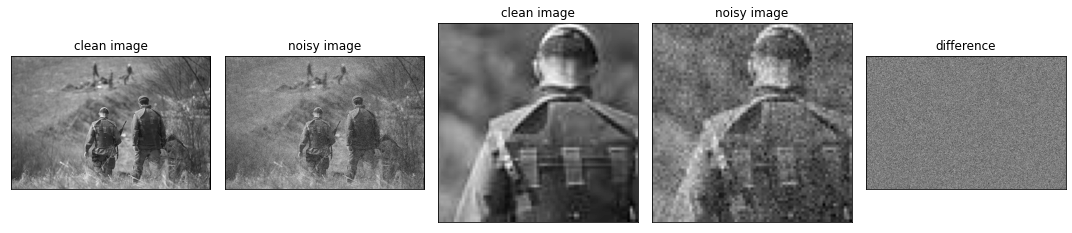

In [6]:
# load a test image and add noise

def add_noise(img, noise_std=0.075):
  return img + np.random.normal(loc=0.0, scale=noise_std, size=img.shape)

test_img_noisy= add_noise(img2)
fig, ax = plt.subplots(1, 5, figsize=(15,16))


ax[0].imshow(img2, cmap='gray')
ax[0].set_title("clean image")
ax[1].set_title("noisy image")
ax[2].set_title("clean image")
ax[3].set_title("noisy image")
ax[1].imshow(test_img_noisy, cmap='gray')
ax[3].imshow(test_img_noisy[125:200,175:250], cmap='gray')
ax[2].imshow(img2[125:200,175:250], cmap='gray')

ax[4].imshow(img2-test_img_noisy, cmap='gray')
ax[4].set_title("difference")
for i in range(5):
  ax[i].set_xticks([]), ax[i].set_yticks([])
plt.tight_layout()

In [7]:
def decode_image(clean_image, noisy_img, dico, patch_size):
    patch_dim = np.prod(patch_size)
    noisy_patches = sklearn.feature_extraction.image.extract_patches_2d(noisy_img, patch_size).reshape(-1, patch_dim)
    intercept = noisy_patches.mean(axis=0)
    noisy_patches -= intercept
    sparse_coding = dico.transform(noisy_patches)
    clean_patches = sparse_coding @ dico.components_
    clean_patches += intercept

    t1 = time.time()
    reconstructed_img = sklearn.feature_extraction.image.reconstruct_from_patches_2d(clean_patches.reshape((-1,) + patch_size), noisy_img.shape)
    t2 = time.time()

    print("reconstruction time : ", t2 - t1)
    print("relative error : ", np.linalg.norm(reconstructed_img-clean_image)/np.linalg.norm(clean_image))
    return reconstructed_img


reconstruction time :  0.548861026763916
relative error :  0.10040594901080822


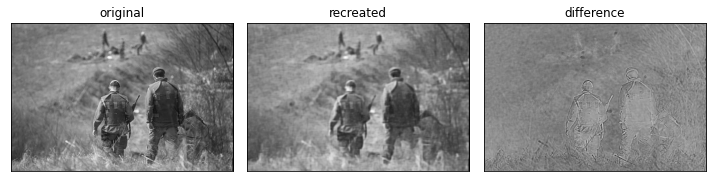

In [8]:
reconstructed_img = decode_image(img2, test_img_noisy, dico, patch_size)
fig, ax = plt.subplots(1, 3, figsize=(10,16))
ax[0].imshow(img2, cmap='gray')
ax[1].imshow(reconstructed_img, cmap='gray')
ax[2].imshow(reconstructed_img-img2, cmap='gray')
ax[0].set_title('original')
ax[1].set_title('recreated')
ax[2].set_title('difference')
for i in range(3):
  ax[i].set_xticks([]), ax[i].set_yticks([])
plt.tight_layout()

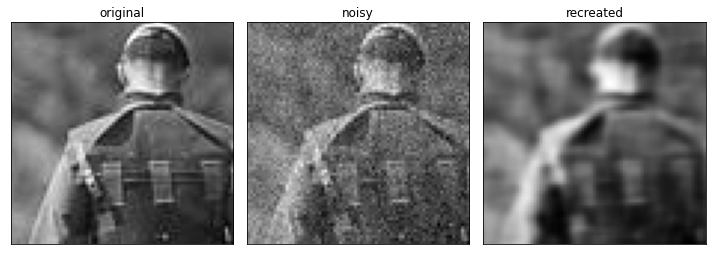

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10,16))
ax[0].imshow(img2[125:200,175:250], cmap='gray')
ax[1].imshow(test_img_noisy[125:200,175:250], cmap='gray')
ax[2].imshow(reconstructed_img[125:200,175:250], cmap='gray')
ax[0].set_title('original')
ax[1].set_title('noisy')
ax[2].set_title('recreated')
for i in range(3):
  ax[i].set_xticks([]), ax[i].set_yticks([])
plt.tight_layout()

training on 149625 patches, patch size (7, 7)
done, time elapsed 7.01371431350708 sec
reconstruction time :  0.3804616928100586
relative error :  0.12663100785859624
training on 146481 patches, patch size (11, 11)
done, time elapsed 12.697623252868652 sec
reconstruction time :  0.39081573486328125
relative error :  0.08733566608997335
training on 141825 patches, patch size (17, 17)
done, time elapsed 18.450562000274658 sec
reconstruction time :  0.3896067142486572
relative error :  0.08434933385979092


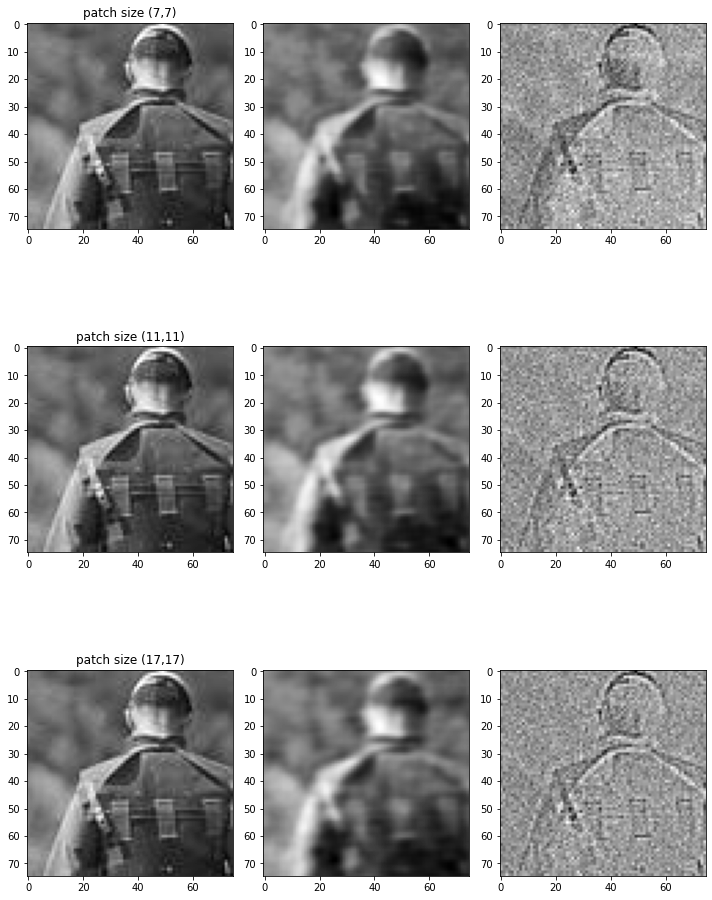

In [10]:
# varying the patch size

patch_sizes = [(7,7), (11,11), (17,17)]
test_imgs = img2
noisy_imgs = add_noise(img2)
fig, ax = plt.subplots(3, 3, figsize=(10,14))
for i in range(3):
    dico = train_dico(img1, k=100, patch_size=patch_sizes[i])
    reconstructed_img = decode_image(img2, test_img_noisy, dico, patch_sizes[i])
    ax[i, 0].imshow(img2[125:200,175:250], cmap='gray')
    ax[i, 1].imshow(reconstructed_img[125:200,175:250], cmap='gray')
    ax[i, 2].imshow(reconstructed_img[125:200,175:250]-test_img_noisy[125:200,175:250], cmap='gray')
    
    ax[i, 0].set_title("patch size ({},{})".format(*patch_sizes[i]))
    
    

plt.tight_layout()   